# Episode 2 -- Histograms

* Basic Idea: Use area to compare sample ratios, instead of point counts
* Easier to answer questios like: "How many voters are older than 30, when presented with a histogram, than a table or a rugplot."
* Both a visualization method and a data-storage format

# Building your own Histogram

1. Define value range of histogram `bin_min`, `bin_max`
2. Divide range into bins `bin[0], ..., bin[k]`
3. The bins may have variying width 
4. Count the number of samples in each bin `sample_count[k]`
5. Draw a rectangle for each bin with height:
   - `h[k] = sample_count[k]` -- non normalized 
   - `h[k] = sample_count[k] / bin_width[k]` -- normalized case
   

In [2]:
from matplotlib import pyplot as plt


In [3]:
import numpy as np
X = np.loadtxt("DataSets/RequestRates.csv", delimiter=",")[:,1]

# Step 1: Represent bins via list of left-edges
bin_left = [
    500, 700, 800, 900, 1000, 1500, 1800, 2000, 2200
]

bin_min = bin_left[0]
bin_max = bin_left[-1]
bins = [ [bin_left[i-1],bin_left[i]] for i in xrange(1, len(bin_left)) ]

print "Bins: ", bins

Bins:  [[500, 700], [700, 800], [800, 900], [900, 1000], [1000, 1500], [1500, 1800], [1800, 2000], [2000, 2200]]


In [4]:
# Step2: Count number of samples in bins
def count(X, bins):
    def findBin(x, bins):
        for i, bin in enumerate(bins):
            left, right = bin
            if left <= x and x < right:
                return i
        return None
    
    count = [0] * len(bins)
    for x in X:
        i = findBin(x, bins)
        if i != None:
            count[i] += 1

    return count

sample_count = count(X, bins)

print "Counts:", sample_count

Counts: [0, 10, 8, 4, 25, 23, 4, 2]


In [5]:
def sample_count(bins, X):
    bin_count = len(bins) - 1
    counts = [0] * bin_count
    for x in X:
        for bin_idx in range(bin_count):
            if (bins[bin_idx] <= x) and (x < bins[bin_idx + 1]):
                counts[bin_idx] += 1
    return counts

In [6]:
sample_count([500, 700, 800, 900, 1000, 1500, 1800, 2000, 2200], X)

[0, 10, 8, 4, 25, 23, 4, 2]

In [19]:
def plot_histogram(bins, X,**kwargs):
    bin_widths = [ float(bins[i] - bins[i-1]) for i in range(1,len(bins)) ]
    sample_counts = sample_count(bins, X)
    bin_heights = [ count/width for count, width in zip(sample_counts, bin_widths) ]
    bin_lefts = bins[:-1]
    return bar_chart(bin_lefts,width=bin_widths,height=bin_heights,**kwargs)

In [13]:
from matplotlib.pyplot import bar as bar_chart

<Container object of 8 artists>

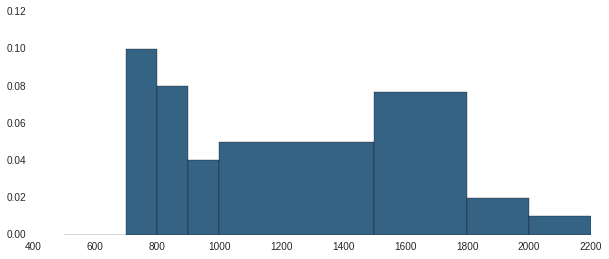

In [25]:
bins = [500, 700, 800, 900, 1000, 1500, 1800, 2000, 2200]

import seaborn as sns
color = sns.color_palette("Blues_d")[1]

%matplotlib inline
plt.figure(figsize=(10,4))
plt.xlim=(500,2200)
plot_histogram(bins,X, color=color)

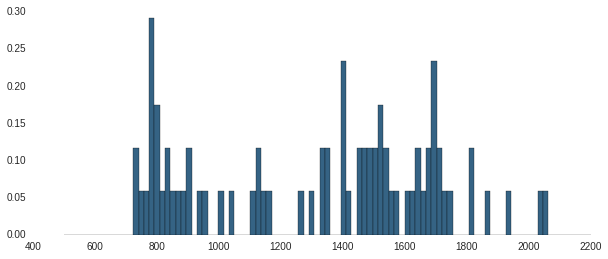

In [32]:
bins=np.linspace(500,2200,100)
import seaborn as sns
color = sns.color_palette("Blues_d")[1]

%matplotlib inline
plt.figure(figsize=(10,4))
plt.xlim=(500,2200)

ax=plot_histogram(bins,X, color=color)

In [17]:
a=ax[0]

In [57]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

# Step3: Plot bar chart
def my_hist(X, bins, normed=True, **kwargs):
    bin_left = [ l for l, r in bins ]
    bin_width = [ r-l  for l,r in bins ]
    bin_height = [ 
        float(c) / w if normed else c 
        for c,w in zip(count(X, bins), bin_width)
    ]
    plt.bar(bin_left,width=bin_width,height=bin_height, **kwargs)

plt.figure(figsize=(15,5))
my_hist(X,bins)
sns.rugplot(X)

TypeError: 'int' object is not iterable

In [4]:
import seaborn as sns

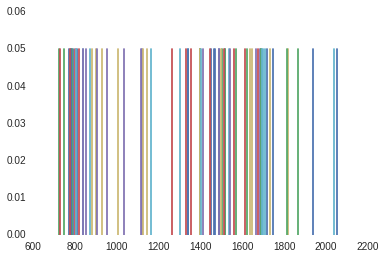

In [5]:
sns.rugplot(X)

# The choice of bins influences the look of the histogram

In [143]:
def plot_hist(X,  bin_min, bin_max, bin_width):
    plt.figure(figsize=(15,5))
    bins =[ [i, i+bin_width] for i in np.arange(bin_min, bin_max, bin_width) ]
    my_hist(X,bins)
    print "Histogram with bin_width ", bin_width
    plt.show()

Histogram with bin_width  5


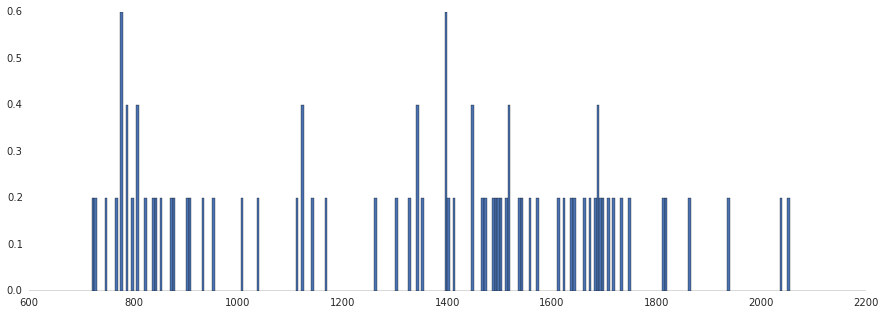

In [144]:
bin_min = 600
bin_max = 2200
plot_hist(X, bin_min, bin_max, 5)

#--> Looks almost like the rugplot

Histogram with bin_width  50


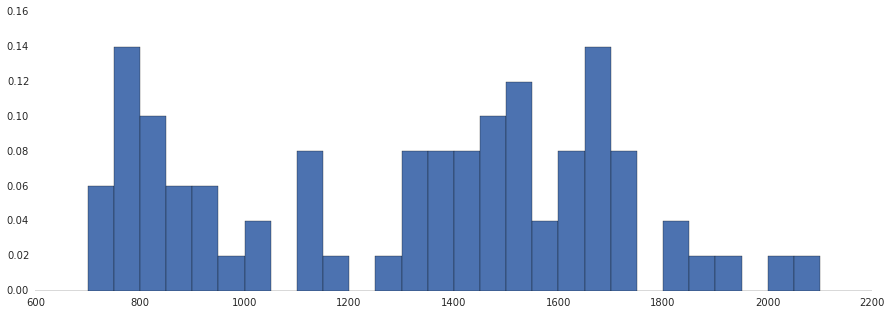

In [58]:
plot_hist(X, bin_min, bin_max, 50)

Histogram with bin_width  500


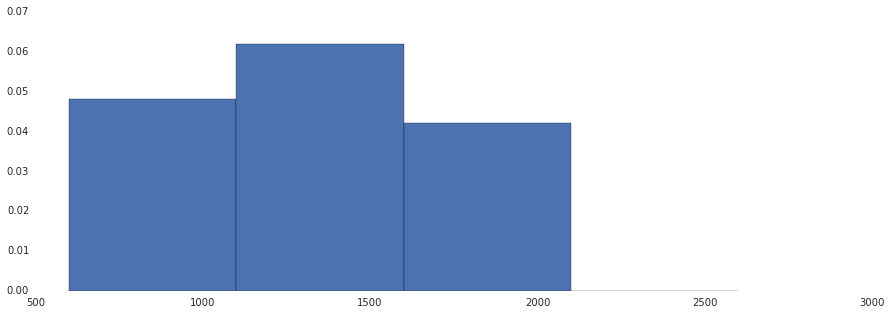

In [59]:
plot_hist(X, bin_min, bin_max, 500)

Histogram with bin_width  2000


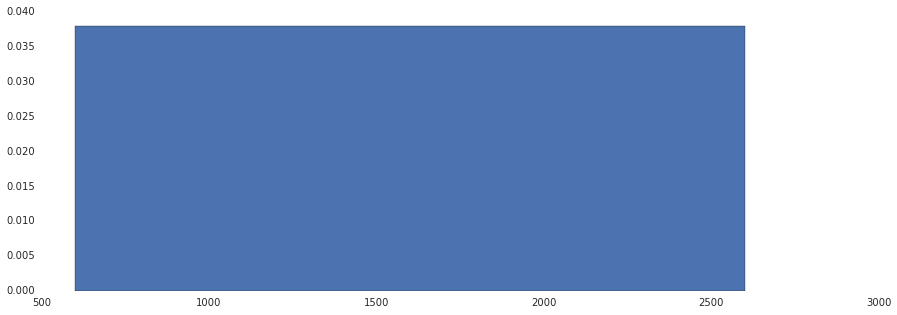

In [62]:
plot_hist(X, bin_min, bin_max, 2000)
# -> Only the total count is displayed

## Common bin-width choices

Remarks:
* Can convert `bin_count` and `bin_width` using relation $$ bin\_max - bin\_min = bin\_count \cdot bin\_width.$$

* Choices `bin_min=min(X)` and `bin_max=max(X)` are common. But: dependence on input data.

Choices for bin-width:

* Excel: Let $n$ be the number of samples, then:

  $$ bin\_count = \sqrt{n} $$

* Scott's normal reference rule

  $$ bin\_width = \frac{3.5 \sigma}{n^{1/3}} $$

  where $\sigma$ is the standard deviation (cf. later).
  This is optimal for random samples of normally distributed data, in a certain sense.

* Freedman–Diaconis rule

  $$ bin\_width = \frac{2 IQR}{n^{1/3}} $$
  
  where IQR is the inter-quartile range (cf. later). Like Scott's rule but more robust agains outliers.

# A pragmatic choice: HDR Histograms

Example: A decimal HDR Histogram with precision=2 has bin boundaries:
  
    .... 1.0,  1.1,  1.2, ... 1.9,  2.0,  2.1, ...., 9.9; --- bin width = 0.1
         10.0, 11.0, 12.0 ... 19.0, 20.0, 21.0 ...., 99 ; --- bin width = 1
         ...

** Properties: **
* Captures large part of float range
* Bin boundaries do not depend on data! -> Can aggregate counts!
* Bin width increase with growing values
* Allows compact memory representation
* Implementation available at http://hdrhistogram.org/

In [111]:
# To be precise:

import math
def HDR_bin_width(x):
    if x == 0: return 0
    sign = x / abs(x)
    return sign * 10 ** ( math.floor(math.log10(abs(x)) - 1 ) )

def HDR_bin_left(x):
    w = bin_width(x)
    if w == 0: return 0
    return math.floor(x / w) * w

def HRD_bin_right(x):
    return bin_left(x) + bin_width(x)

In [198]:
[ HDR_bin_width(x) for x in 0,0.01,0.1,1,2,9,9.9,10 ]

[0, 0.001, 0.01, 0.1, 0.1, 0.1, 0.1, 1.0]

In [199]:
def HDR_hist(X):
    count = {}
    for x in X:
        l = HDR_bin_left(x)
        count[l] = count.get(l,0) + 1
    bin_left = sorted(count.keys())
    bin_width = [ HDR_bin_width(l) for l in bin_left ]
    bin_height = [ count[l] / HDR_bin_width(l)
        for l in bin_left
    ]
    plt.figure(figsize=(15,5))
    plt.bar(bin_left,width=bin_width,height=bin_height)

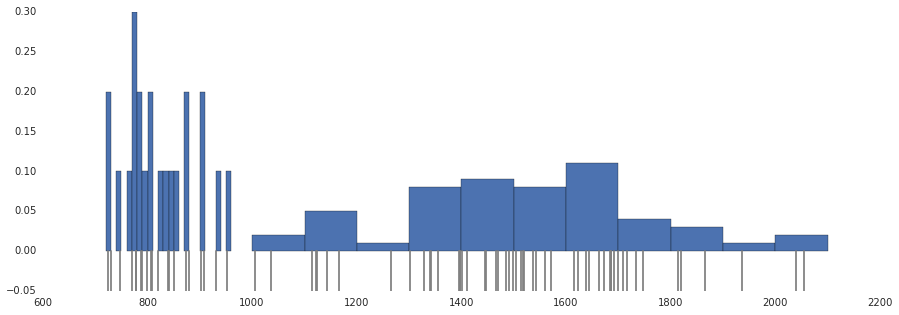

In [200]:
HDR_hist(X)
sns.rugplot(X,height=-0.05, color="grey")

# Example: Heatmaps of HDR Histograms

* Can use color coding for bin count
* Allows to show many histograms at once
* Harder to read off values
* Uses HDR Histogram

<figure>
<center><img src="img/Circonus_Histogram.png"/></center>
<figcaption>A histogram metric.</figcaption>
</figure>


Traditionally only a single request per sampling period is recorded.
<figure>
<center><img src="img/example_histogram_mean.png"/></center>
<figcaption>Histogram with mean value.</figcaption>
</figure>

Multimodal and logarithmic structures are not visible.

- share: https://share.circonus.com/shared/graphs/a759d10b-7001-4608-9d6a-283870cb0e84/2FcJcz
- graph: https://lethargy.circonus.com/trending/graphs/view/a759d10b-7001-4608-9d6a-283870cb0e84

## Digression: Kernel Density Estimators

1. Replace 'rugs" with little functions (e.g. triangles, rectangles, normal-distributions)
2. Sum all functions

<center>
<img src="http://upload.wikimedia.org/wikipedia/en/4/41/Comparison_of_1D_histogram_and_KDE.png" width='400px'>

Source: Wikipdeia, CC BY-SA 3.0, by Drleft <br>
http://en.wikipedia.org/wiki/Kernel_density_estimation
</center>

Remarks:

* Smooth version of Histogram
* Better approximation for pdf (cf. later)
* More expensive to compute
* Harder to define
* Choices of function and width invloved. Similar to Histogram.


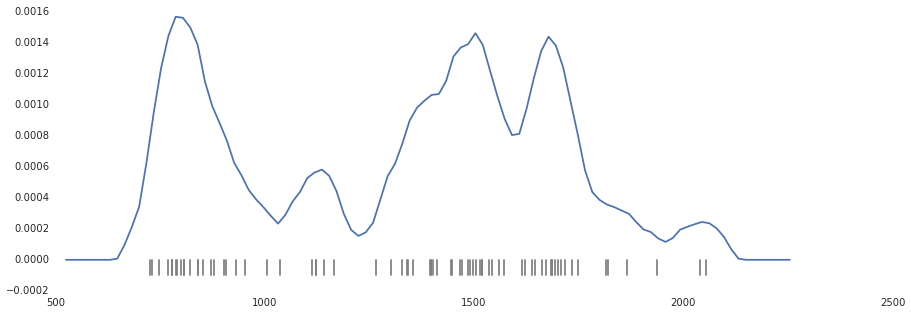

In [214]:
from sklearn.neighbors import KernelDensity

X = np.loadtxt("DataSets/RequestRates.csv", delimiter=",")[:,1]

KDE=KernelDensity(kernel='epanechnikov', bandwidth=80)
KDE.fit(X[:,np.newaxis])
grid=np.linspace(min(X)-200, max(X)+200,100)
kde =np.exp(KDE.score_samples(grid[:,np.newaxis]))

plt.figure(figsize=(15,5))
plt.plot(grid, kde)
sns.rugplot(X, color='grey', height=-.0001)